In [1]:
file_path = "Reflectance_estimation/"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
from skimage import io

In [2]:
def delta_e_cie2000(lab1, lab2):
    # Constants
    kL = 1
    kC = 1
    kH = 1

    L1, a1, b1 = lab1
    L2, a2, b2 = lab2

    # CIE 2000 formula
    L_bar_prime = 0.5 * (L1 + L2)
    C1 = np.sqrt(a1**2 + b1**2)
    C2 = np.sqrt(a2**2 + b2**2)
    C_bar = 0.5 * (C1 + C2)
    C_bar7 = C_bar**7

    G = 0.5 * (1 - np.sqrt(C_bar7 / (C_bar7 + 25**7)))
    a1_prime = (1 + G) * a1
    a2_prime = (1 + G) * a2

    C1_prime = np.sqrt(a1_prime**2 + b1**2)
    C2_prime = np.sqrt(a2_prime**2 + b2**2)
    C_bar_prime = 0.5 * (C1_prime + C2_prime)

    h1_prime = np.degrees(np.arctan2(b1, a1_prime)) % 360
    h2_prime = np.degrees(np.arctan2(b2, a2_prime)) % 360

    H_bar_prime = h1_prime + h2_prime
    if abs(h1_prime - h2_prime) > 180:
        H_bar_prime += 360
    H_bar_prime *= 0.5

    T = 1 - 0.17 * np.cos(np.radians(H_bar_prime - 30)) \
        + 0.24 * np.cos(np.radians(2 * H_bar_prime)) \
        + 0.32 * np.cos(np.radians(3 * H_bar_prime + 6)) \
        - 0.20 * np.cos(np.radians(4 * H_bar_prime - 63))

    delta_h_prime = h2_prime - h1_prime
    if abs(delta_h_prime) > 180:
        if h2_prime <= h1_prime:
            delta_h_prime += 360
        else:
            delta_h_prime -= 360

    delta_L_prime = L2 - L1
    delta_C_prime = C2_prime - C1_prime
    delta_H_prime = 2 * np.sqrt(C1_prime * C2_prime) * np.sin(np.radians(delta_h_prime * 0.5))

    S_L = 1 + ((0.015 * (L_bar_prime - 50) ** 2) / np.sqrt(20 + (L_bar_prime - 50) ** 2))
    S_C = 1 + 0.045 * C_bar_prime
    S_H = 1 + 0.015 * C_bar_prime * T

    delta_theta = 30 * np.exp(-(((H_bar_prime - 275) / 25) ** 2))
    R_C = 2 * np.sqrt(C_bar7 / (C_bar7 + 25**7))
    R_T = -R_C * np.sin(2 * np.radians(delta_theta))

    delta_E = np.sqrt(
        (delta_L_prime / (kL * S_L)) ** 2 +
        (delta_C_prime / (kC * S_C)) ** 2 +
        (delta_H_prime / (kH * S_H)) ** 2 +
        R_T * (delta_C_prime / (kC * S_C)) * (delta_H_prime / (kH * S_H))
    )

    return delta_E

def color_error(image1_path,image2_path):
    image1 = io.imread(image1_path)
    image2 = io.imread(image2_path)
    # Ensure images are in uint8 format
    if image1.dtype != np.uint8:
        image1 = (image1 * 255).astype(np.uint8)
    if image2.dtype != np.uint8:
        image2 = (image2 * 255).astype(np.uint8)
    # Remove the alpha channel if it exists
    if image1.shape[-1] == 4:
        image1 = image1[..., :3]
    if image2.shape[-1] == 4:
        image2 = image2[..., :3]
    # Ensure the images have the same dimensions
    if image1.shape != image2.shape:
        raise ValueError("Images must have the same dimensions")
    # Convert images to LAB color space
    image1_lab = cv2.cvtColor(image1, cv2.COLOR_RGB2LAB)
    image2_lab = cv2.cvtColor(image2, cv2.COLOR_RGB2LAB)

    # Scale LAB values to match theoretical ranges
    image1_lab = np.copy(image1_lab).astype(np.float64)
    image2_lab = np.copy(image2_lab).astype(np.float64)

    image1_lab[:, :, 0] = image1_lab[:, :, 0] * (100 / 255)  # L channel
    image1_lab[:, :, 1] = image1_lab[:, :, 1] - 128          # a channel
    image1_lab[:, :, 2] = image1_lab[:, :, 2] - 128          # b channel

    image2_lab[:, :, 0] = image2_lab[:, :, 0] * (100 / 255)  # L channel
    image2_lab[:, :, 1] = image2_lab[:, :, 1] - 128          # a channel
    image2_lab[:, :, 2] = image2_lab[:, :, 2] - 128          # b channel

    # Flatten the images for easier processing
    image1_lab_flat = image1_lab.reshape((-1, 3))
    image2_lab_flat = image2_lab.reshape((-1, 3))

    # Compute Delta E 2000 for each pair of pixels
    delta_e_values = np.array([delta_e_cie2000(lab1, lab2) for lab1, lab2 in zip(image1_lab_flat, image2_lab_flat)])
    delta_e_values_mean = np.mean(delta_e_values)
    # Reshape the delta_e_values to match the image dimensions, if u wanna plot
    delta_e_image = delta_e_values.reshape(image1_lab.shape[:2])
    return delta_e_image,delta_e_values_mean

2.2743464063590455


(-0.5, 2135.5, 1523.5, -0.5)

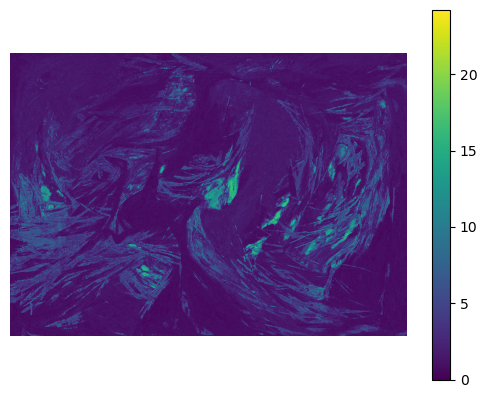

In [8]:
gt_path = file_path+"Paintings/Artificial_yellowing/Completely_yellowfilter_0_7_0_7_0_7.png"
out_path = file_path+"Paintings/Artificial_yellowing/Dirt layer of yellowed Completely_0_7_0_7_0_7.png"
delta_E, delta_e_values_mean = color_error(gt_path,out_path)
print(delta_e_values_mean)
plt.imshow(delta_E)
plt.colorbar() 
plt.axis('off')